# Setup: Import Various Modules

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from IPython.core.display import display
%matplotlib inline

# Import Data
Use A Dictionary. Create A Default Dictionary. First iterate Through The First Sentence
In The Text File Which Will Include The Headers. Save The As Keys In The Default Dictionary
Go To The Next Sentence. The First Word Corresponds To The Column
If There Is No Value, The Cell Will Take The Average For The Row
If The Line Contains Too Few, Then We Will Fill In The Last Cell With The Average
If There Are More Cells Than Headers Then We Are Missing A Header. Create A New Unknown Header

The Dictionary Value Will Be A List, Which We Will Append New Values Too

Once The Process Is Complete We Will Use The Dictionary And Convert Into A Pandas
DataFrame

We Will Customize CSV's In The Following Ways:
i)   Account for | (Tabular CSV's)
ii)  Account For Comma's Within Quotation Marks " Therefore, I am" Could Erronously
      Be Split. We Will Have a Boolean Definition Which Engages When We Hit A Quotation
      Thereby Precluding Splitting When the Boolean Is Engaged. After An Unquote When
      The Bool Is Disengaged, When We Encounter A Comma, We Can Split As Normal

In [63]:
class quotation_search:
    def __init__(self):
        self.state = False
    def quotation_encountered(self):
        if self.state == False:
            self.state = True
        else:
            self.state = False
    def is_quotation_engaged(self):
        return self.state
def split(line, split_location):
    split_list = []
    starting_index = 0
    line.rstrip()
    for location in split_location:
        split_data = line[starting_index: location]
        split_list.append(split_data)
        starting_index = location + 1
    split_data = line[starting_index:]
    split_list.append(split_data)
    return split_list
def delimiter_check(first_sentence):
    if "|" in first_sentence:
        return "|"
    else:
        return ","
def stray_end_comma_adjustment(final_char_position, split_location_array, number_of_columns):
    """ A Line Which Contains A Trailing Comma ("DateTime,"mm",)
        Will Over State The Number of Columns.
        Action: Reduce The Column Count By One"""
    if (final_char_position - 1) == split_location_array[-1]:
         number_of_columns -= 1
    return number_of_columns
def cleanse_split_heading_data(split_columns):
    column_headings = []
    data_frame_dictionary = {}
    for column in split_columns:
        column = re.sub(r'^"|"$', '', column)
        column_headings.append(column)
        data_frame_dictionary[column] = []
    if column_headings[-1] == "":
        column_headings = column_headings[:-1]
    return column_headings, data_frame_dictionary
# encoding='utf-8-sig'
def create_data_frame(file_name):
    with open(file_name, "r", encoding='utf-8-sig') as f_handle:
        # Empty Cells Will Need To Have An Average Of All Values: Come Back To This

        # The Data Frame Dictionary Will Be Used To Create A Pandas DataFrame
        data_frame_dictionary = {}

        # List Of Column Headings Allows Us To Reference The Array As We Store Data Into The Correct Column
        column_headings = []

        # Create The Lines Object (The Entire Data Split Into Sentences)
        sentences = f_handle.readlines()

        # We Need To Keep Track Of Quotation Marks, As Delimiters Symbols Which Are Surrounded By Quotation
        # Marks Must Be Ignored.
        quotation_obj = quotation_search()

        # Counter == 0 Allows Us Check The First Row, Which Is Needed For Headers
        counter = 0
        number_of_columns = 1
        for line in sentences:
            # Ignore Blank Lines
            if line == "\n":
                continue
            delimiter_count = 0
            # The First Row Is The Headers
            split_location = []
            if counter == 0:
                # Establish What The Delimiter Is
                delimiter = delimiter_check(line)
                for char_position, char in enumerate(line):
                    if char == "\"":
                        quotation_obj.quotation_encountered()
                    if char == delimiter and quotation_obj.is_quotation_engaged() == False:
                        split_location.append(char_position)
                        number_of_columns += 1
                # Stray End Comma Adjustment
                number_of_columns = stray_end_comma_adjustment(char_position,split_location,number_of_columns)
                split_columns = split(line.rstrip(), split_location)

                # Cleanse The Split Headers Data
                column_headings, data_frame_dictionary = cleanse_split_heading_data(split_columns)
                counter = counter + 1
            # Dealing With The Data (Row 1 +) And Not Headers
            else:
                for char_position, char in enumerate(line):
                    if char == "\"":
                        quotation_obj.quotation_encountered()
                    # A Comma Engaged Unbounded By Quotation Marks Is A Split Point
                    # Record The Location In The Line So We Can Split It
                    if char == delimiter and quotation_obj.is_quotation_engaged() == False:
                        delimiter_count = delimiter_count + 1
                        # Ignore Columns With No Header
                        if delimiter_count == number_of_columns:
                            break
                        else:
                            split_location.append(char_position)
                split_data = split(line[:char_position].rstrip(), split_location)
                for i in range(len(split_data)):
                    if split_data[i] == "":
                        data_frame_dictionary[column_headings[i]].append(np.nan)
                    else:
                        # Cleanse Data
                        split_data[i] = re.sub(r'^"|"$', '', split_data[i])
                        data_frame_dictionary[column_headings[i]].append(split_data[i])
                row_number_of_columns = len(split_data)
                if row_number_of_columns < number_of_columns:
                    for i in range(row_number_of_columns,number_of_columns):
                        data_frame_dictionary[column_headings[i]].append(np.nan)
    return data_frame_dictionary


file_name = ["barometer-1617.csv", "indoor-temperature-1617.csv", "outside-temperature-1617.csv","rainfall-1617.csv"]
i = 0
data_frame = None
previous_file = None
for file_csv in file_name:
    data_frame_dictionary = create_data_frame(file_csv)
    data_frame_dictionary = pd.DataFrame.from_dict(data_frame_dictionary, orient='index').transpose()
    frame = pd.DataFrame(data_frame_dictionary)
    split_file_name = re.findall(r"[\w']+", file_csv)
    if i == 0:
        data_frame = frame
        i = i + 1
        previous_file = split_file_name[0]
    else:
        # Not All Of The Data Frames Have The Same Number Of Rows. The Default Position
        # For Merge Is To Delete Rows Which Are Uncommon To The Data Frames Being Merged
        data_frame = pd.DataFrame.merge(frame, data_frame, on="DateTime",how='right', suffixes=(f"_{split_file_name[0]}",f"_{previous_file}"))
        previous_file = split_file_name[0]

pd.set_option('max_colwidth', 20)
display(data_frame.head(10).style)

,DateTime,mm,Temperature_outside,Temperature_range (low)_outside,Temperature_range (high)_outside,Humidity,Temperature_indoor,Temperature_range (low)_indoor,Temperature_range (high)_indoor,Baro
0,2016-10-09 00:00:00,0,10.66,7.2,13.8,54,21.93,21,22.8,1021
1,2016-10-10 00:00:00,0,8.94,5.6,12.8,52,21.77,20.4,23.6,1019.9
2,2016-10-11 00:00:00,0,8.69,5.3,14.3,51,21.36,19.9,23,1015.8
3,2016-10-12 00:00:00,0,11.55,9,14.9,51,21.44,20,23.6,1013.2
4,2016-10-13 00:00:00,0,9.4,6,13.3,52,21.22,20.1,22.3,1005.9
5,2016-10-14 00:00:00,1.1,9.85,6.8,13.3,52,21.02,19.6,22.6,998.6
6,2016-10-15 00:00:00,2.1,10.72,8.2,14.7,53,21.4,20.3,22.5,998
7,2016-10-16 00:00:00,8.4,11.28,7.8,14.5,53,21.43,20,23,1002.2
8,2016-10-17 00:00:00,1.1,11.84,10,15,53,21.67,20.5,22.7,1009.8
9,2016-10-18 00:00:00,3.1,10.24,8.2,12.7,54,21.75,20.6,23.1,1013.4


# Averages
Averages

In [64]:
header = [column for column in data_frame.head(0)]
Averages = [[header, data_frame[header].astype(float).mean(skipna=True),data_frame[header].astype(float).std(skipna=True) ] for header in [column for column in data_frame.head(0)] if header != "DateTime"]
#print(Averages)
table = pd.DataFrame(Averages, columns=["DataType", "Averages", "Standard Deviation"])
display(table)






,DataType,Averages,Standard Deviation
0,mm,1.553125,3.328302
1,Temperature_outside,11.138877,5.355042
2,Temperature_rang...,7.865634,4.878930
3,Temperature_rang...,15.522535,7.034981
4,Humidity,48.519774,5.188886
5,Temperature_indoor,21.827885,2.058307
6,Temperature_rang...,20.555932,2.405125
7,Temperature_rang...,23.532768,1.702157
8,Baro,1009.993803,9.865821


Distribution Plot: Temperature_Outside

/home/ciaran/git_workspace/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ciaran/git_workspace/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ciaran/git_workspace/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

<AxesSubplot:xlabel='Temperature_range (high)_outside', ylabel='Density'>

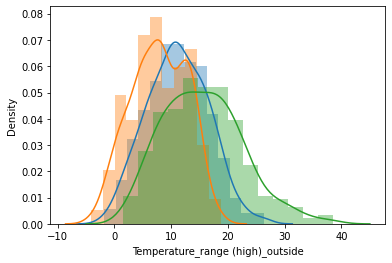

In [65]:
sns.distplot(data_frame["Temperature_outside"])
sns.distplot(data_frame["Temperature_range (low)_outside"])
sns.distplot(data_frame["Temperature_range (high)_outside"])

Distribution Plot: Temperature_indoor

/home/ciaran/git_workspace/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ciaran/git_workspace/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ciaran/git_workspace/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

<AxesSubplot:xlabel='Temperature_range (high)_indoor', ylabel='Density'>

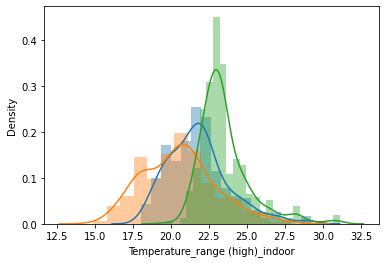

In [66]:
sns.distplot(data_frame["Temperature_indoor"])
sns.distplot(data_frame["Temperature_range (low)_indoor"])
sns.distplot(data_frame["Temperature_range (high)_indoor"])

# Bla Bla

TypeError: set() takes no keyword arguments

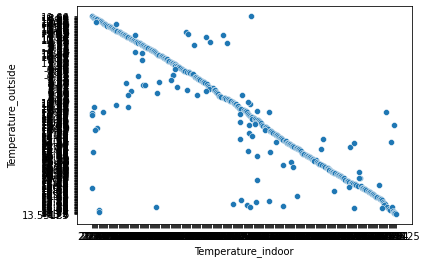

In [74]:
sns.scatterplot(data=data_frame, x="Temperature_indoor",y="Temperature_outside")

